
# Exploratory Data Analysis - Customer Purchasing Dataset

Understanding purchasing behaviour is essential before building the LLM-powered assistant. This notebook explores the transactional data to surface trends across customers, products, pricing tiers, and time.



## 1. Imports & Data Loading

We first load the dataset and establish some helpful display defaults for exploration.


In [1]:

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 20
pd.options.display.max_columns = None
pd.options.display.float_format = '{:,.2f}'.format

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10


In [2]:

DATA_PATH = 'Dataset_product_orders.csv'
df = pd.read_csv(DATA_PATH, parse_dates=['Date'])
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)
print(f"Loaded {df.shape[0]:,} rows and {df.shape[1]} columns")
df.head()


Loaded 1,000 rows and 14 columns


,Date,Customer_ID,Customer,Pricelist,Order_Lines_Product_ID,Product_Display_Name,Product_Sub_Category,Product_Category,Broad_Category,Order_Lines_Unit_Price,Order_Quantity,Subtotal,Total_OrderQuantity,Total_Subtotal
0,2025-02-18,CUST_025,John Guerra,Wholesale,PROD_006,Product 6,Bakery,Food,Grocery,14.53,10,145.30,10,145.30
1,2025-02-18,CUST_035,Kelsey Shaw,Wholesale,PROD_027,Product 27,Dairy,Household,Home Essentials,65.11,8,520.88,8,520.88
2,2025-02-18,CUST_012,Melissa Montgomery,Retail,PROD_013,Product 13,Fruits,Food,Grocery,83.14,7,581.98,7,581.98
3,2025-02-18,CUST_021,Grace Wright,Retail,PROD_096,Product 96,Bakery,Household,Grocery,28.18,3,84.54,3,84.54
4,2025-02-18,CUST_042,Jorge Morris,Wholesale,PROD_063,Product 63,Beverages,Household,Grocery,35.48,6,212.88,6,212.88



## 2. Dataset Overview

High-level structure, cardinality, and data type checks to understand what we are working with.


In [3]:

overview = {
    'rows': df.shape[0],
    'columns': df.shape[1],
    'date_range': f"{df['Date'].min().date()} -> {df['Date'].max().date()}",
    'unique_customers': df['Customer_ID'].nunique(),
    'unique_products': df['Product_Display_Name'].nunique(),
    'broad_categories': df['Broad_Category'].nunique(),
    'pricelists': df['Pricelist'].unique().tolist(),
}
pd.Series(overview)


rows                                    1000
columns                                   14
date_range          2025-02-18 -> 2025-08-19
unique_customers                          50
unique_products                          100
broad_categories                           2
pricelists               [Wholesale, Retail]
dtype: object

In [4]:

info_df = (
    pd.DataFrame({
        'dtype': df.dtypes.astype(str),
        'n_unique': df.nunique(),
        'missing_count': df.isna().sum(),
        'missing_pct': (df.isna().mean() * 100).round(2),
    })
    .sort_values('missing_pct', ascending=False)
)
info_df


,dtype,n_unique,missing_count,missing_pct
Date,datetime64[ns],183,0,0.00
Customer_ID,object,50,0,0.00
Customer,object,50,0,0.00
Pricelist,object,2,0,0.00
Order_Lines_Product_ID,object,100,0,0.00
Product_Display_Name,object,100,0,0.00
Product_Sub_Category,object,5,0,0.00
Product_Category,object,3,0,0.00
Broad_Category,object,2,0,0.00
Order_Lines_Unit_Price,float64,950,0,0.00


In [5]:

duplicate_lines = df.duplicated().sum()
print(f"Duplicate (full) rows: {duplicate_lines}")

numeric_cols = ['Order_Lines_Unit_Price', 'Order_Quantity', 'Subtotal', 'Total_OrderQuantity', 'Total_Subtotal']
df[numeric_cols].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95]).T


Duplicate (full) rows: 0


,count,mean,std,min,10%,25%,50%,75%,90%,95%,max
Order_Lines_Unit_Price,"1,000.00",50.48,29.04,1.08,10.73,25.86,50.24,75.83,90.80,95.45,99.95
Order_Quantity,"1,000.00",5.45,2.90,1.00,1.00,3.00,5.00,8.00,10.00,10.00,10.00
Subtotal,"1,000.00",273.72,231.46,1.08,34.82,85.95,210.50,398.16,645.97,744.04,992.50
Total_OrderQuantity,"1,000.00",6.19,3.81,1.00,2.00,3.00,6.00,9.00,10.00,12.00,24.00
Total_Subtotal,"1,000.00",311.61,269.85,1.08,38.08,94.59,245.76,456.84,682.89,821.27,"1,655.33"



## 3. Pricing & Spend Distributions

Examine how order unit prices and spend vary by pricing tier.


C:\Users\FCT\AppData\Local\Temp\ipykernel_8836\180394534.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


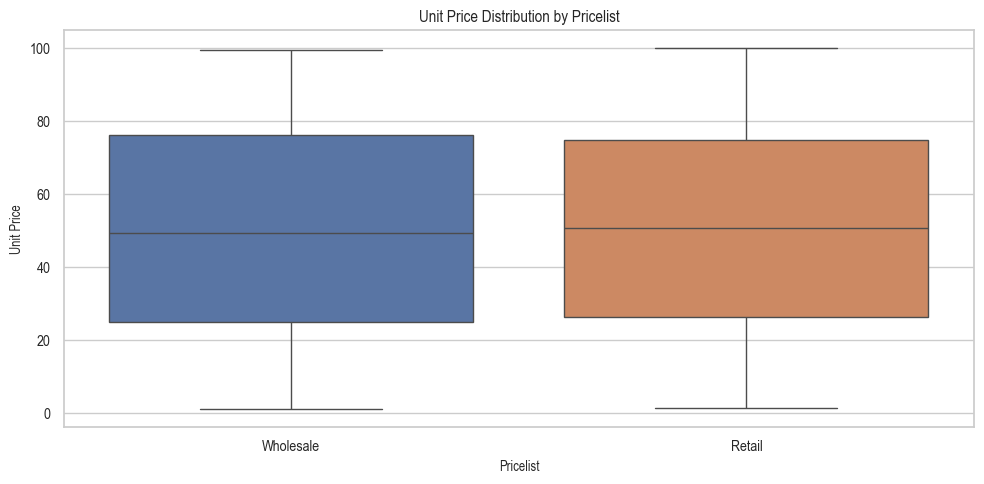

In [6]:

plt.figure()
sns.boxplot(data=df, x='Pricelist', y='Order_Lines_Unit_Price', hue='Pricelist', dodge=False)
plt.title('Unit Price Distribution by Pricelist')
plt.xlabel('Pricelist')
plt.ylabel('Unit Price')
plt.legend().set_visible(False)
plt.tight_layout()
plt.show()


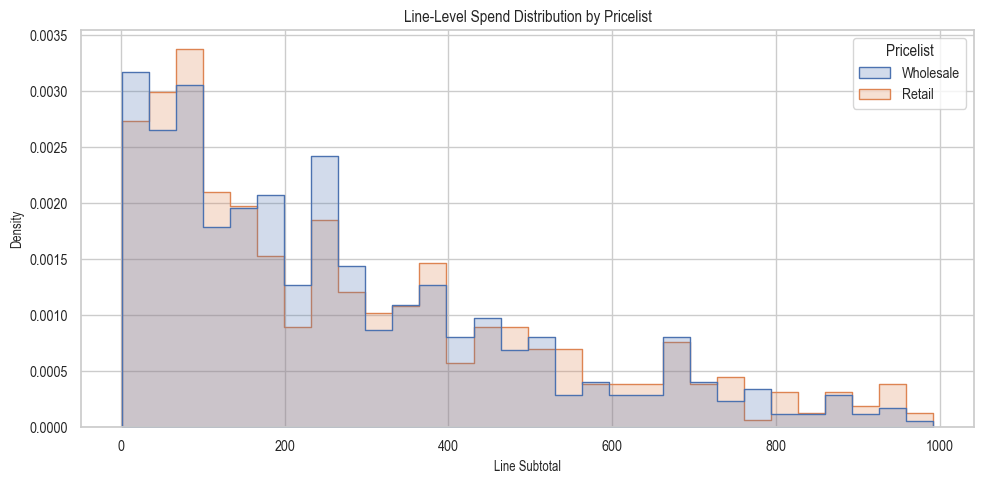

In [7]:

plt.figure()
sns.histplot(data=df, x='Subtotal', hue='Pricelist', bins=30, element='step', stat='density', common_norm=False)
plt.title('Line-Level Spend Distribution by Pricelist')
plt.xlabel('Line Subtotal')
plt.ylabel('Density')
plt.tight_layout()
plt.show()



## 4. Category Performance

Revenue and volume signals across product hierarchies highlight core assortments.


In [8]:

broad_summary = (
    df.groupby('Broad_Category')
      .agg(total_revenue=('Subtotal', 'sum'),
           total_quantity=('Order_Quantity', 'sum'),
           unique_products=('Product_Display_Name', 'nunique'))
      .sort_values('total_revenue', ascending=False)
)
broad_summary.assign(revenue_pct=(broad_summary['total_revenue'] / broad_summary['total_revenue'].sum()).round(3))


,total_revenue,total_quantity,unique_products,revenue_pct
Broad_Category,,,,
Grocery,"142,268.57",2728,100,0.52
Home Essentials,"131,449.31",2722,99,0.48


In [9]:

category_summary = (
    df.groupby(['Broad_Category', 'Product_Category'])
      .agg(total_revenue=('Subtotal', 'sum'),
           total_quantity=('Order_Quantity', 'sum'),
           unique_products=('Product_Display_Name', 'nunique'))
      .sort_values('total_revenue', ascending=False)
      .reset_index()
)
category_summary.head(15)


,Broad_Category,Product_Category,total_revenue,total_quantity,unique_products
0,Grocery,Household,"51,523.30",1048,81
1,Grocery,Food,"48,350.90",855,79
2,Home Essentials,Beverage,"45,838.01",954,82
3,Home Essentials,Household,"44,759.13",954,85
4,Grocery,Beverage,"42,394.37",825,79
5,Home Essentials,Food,"40,852.17",814,85


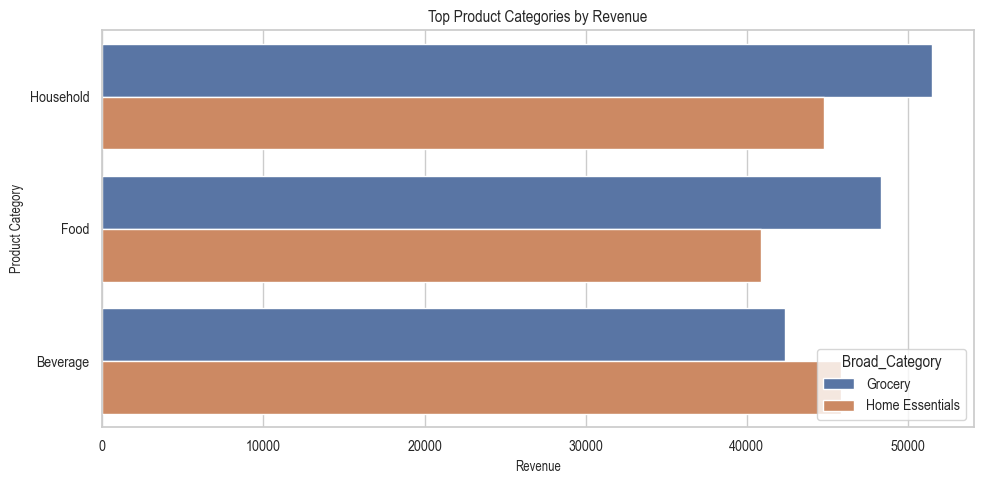

In [10]:

plt.figure()
sns.barplot(data=category_summary.head(10), x='total_revenue', y='Product_Category', hue='Broad_Category')
plt.title('Top Product Categories by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()



## 5. Product Leaders

Identify the products driving the majority of revenue and volume.


In [11]:

product_metrics = (
    df.groupby(['Order_Lines_Product_ID', 'Product_Display_Name', 'Product_Sub_Category', 'Product_Category', 'Broad_Category'])
      .agg(total_revenue=('Subtotal', 'sum'),
           total_quantity=('Order_Quantity', 'sum'),
           average_unit_price=('Order_Lines_Unit_Price', 'mean'),
           customers=('Customer_ID', 'nunique'))
      .sort_values('total_revenue', ascending=False)
      .reset_index()
)
product_metrics.head(15)


,Order_Lines_Product_ID,Product_Display_Name,Product_Sub_Category,Product_Category,Broad_Category,total_revenue,total_quantity,average_unit_price,customers
0,PROD_022,Product 22,Bakery,Household,Home Essentials,"1,813.55",31,59.21,4
1,PROD_081,Product 81,Vegetables,Food,Home Essentials,"1,496.80",20,74.84,2
2,PROD_004,Product 4,Fruits,Food,Grocery,"1,345.08",20,70.10,3
3,PROD_027,Product 27,Dairy,Household,Grocery,"1,331.45",15,86.89,2
4,PROD_100,Product 100,Dairy,Food,Home Essentials,"1,206.84",13,86.44,2
5,PROD_011,Product 11,Beverages,Food,Grocery,"1,163.70",14,80.15,2
6,PROD_024,Product 24,Bakery,Food,Grocery,"1,061.35",15,65.95,2
7,PROD_093,Product 93,Beverages,Household,Home Essentials,"1,054.16",15,68.30,2
8,PROD_045,Product 45,Beverages,Food,Home Essentials,"1,030.74",16,62.44,2
9,PROD_004,Product 4,Vegetables,Household,Grocery,"1,026.23",16,67.97,2


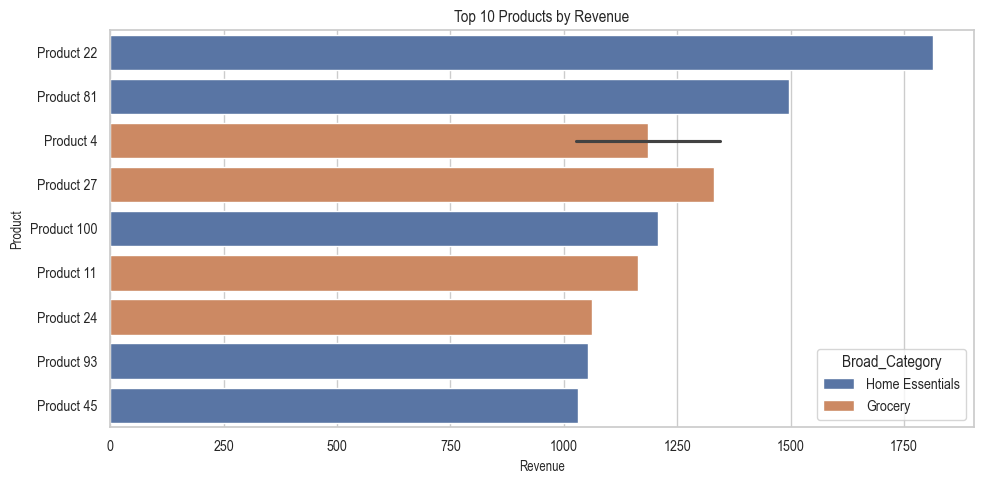

In [12]:

plt.figure()
sns.barplot(data=product_metrics.head(10), x='total_revenue', y='Product_Display_Name', hue='Broad_Category')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Product')
plt.tight_layout()
plt.show()



## 6. Customer Segments

Look at revenue concentration, product breadth, and recency by customer and pricing tier.


In [13]:

customer_metrics = (
    df.groupby(['Customer_ID', 'Customer', 'Pricelist'])
      .agg(total_revenue=('Subtotal', 'sum'),
           total_quantity=('Order_Quantity', 'sum'),
           unique_products=('Product_Display_Name', 'nunique'),
           first_purchase=('Date', 'min'),
           last_purchase=('Date', 'max'))
      .reset_index()
)
customer_metrics['tenure_days'] = (customer_metrics['last_purchase'] - customer_metrics['first_purchase']).dt.days
customer_metrics.sort_values('total_revenue', ascending=False).head(15)


,Customer_ID,Customer,Pricelist,total_revenue,total_quantity,unique_products,first_purchase,last_purchase,tenure_days
22,CUST_012,Melissa Montgomery,Retail,"6,187.15",96,12,2025-02-18,2025-08-05,168
28,CUST_015,Lindsey Glass,Retail,"5,755.33",77,10,2025-03-05,2025-08-09,157
53,CUST_027,Wesley Hart,Wholesale,"5,338.33",92,13,2025-02-24,2025-08-07,164
32,CUST_017,Kimberly Rose,Retail,"4,922.78",71,10,2025-02-24,2025-08-11,168
71,CUST_036,Leslie Murray,Wholesale,"4,834.29",81,14,2025-02-23,2025-07-24,151
51,CUST_026,Adam Johnson,Wholesale,"4,796.87",99,13,2025-03-15,2025-08-17,155
76,CUST_039,Shannon Green,Retail,"4,754.46",91,16,2025-02-26,2025-08-18,173
1,CUST_001,Pamela Tran,Wholesale,"4,707.01",88,13,2025-03-01,2025-08-05,157
96,CUST_049,Elizabeth Bailey,Retail,"4,701.51",92,16,2025-03-08,2025-08-14,159
57,CUST_029,Diana Rojas,Wholesale,"4,447.45",75,11,2025-02-19,2025-08-17,179


In [14]:

pricelist_summary = (
    customer_metrics.groupby('Pricelist')
    .agg(customers=('Customer_ID', 'nunique'),
         total_revenue=('total_revenue', 'sum'),
         total_quantity=('total_quantity', 'sum'),
         avg_revenue_per_customer=('total_revenue', 'mean'),
         median_revenue_per_customer=('total_revenue', 'median'))
)
pricelist_summary


,customers,total_revenue,total_quantity,avg_revenue_per_customer,median_revenue_per_customer
Pricelist,,,,,
Retail,50,"133,927.50",2637,"2,678.55","2,502.01"
Wholesale,50,"139,790.38",2813,"2,795.81","2,679.57"


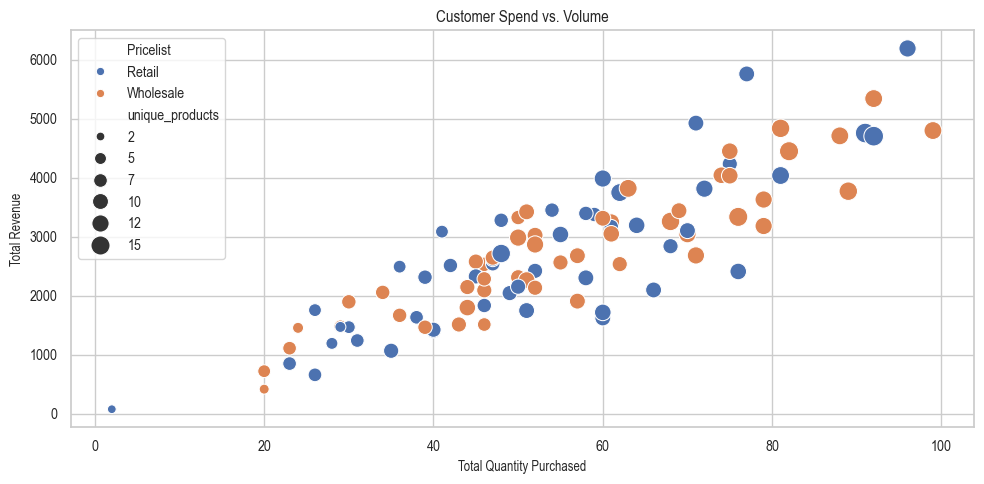

In [15]:

plt.figure()
sns.scatterplot(data=customer_metrics, x='total_quantity', y='total_revenue', hue='Pricelist', size='unique_products', sizes=(40, 200))
plt.title('Customer Spend vs. Volume')
plt.xlabel('Total Quantity Purchased')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.show()



## 7. Temporal Patterns

Trend analysis to surface seasonality, growth, and category momentum over time.


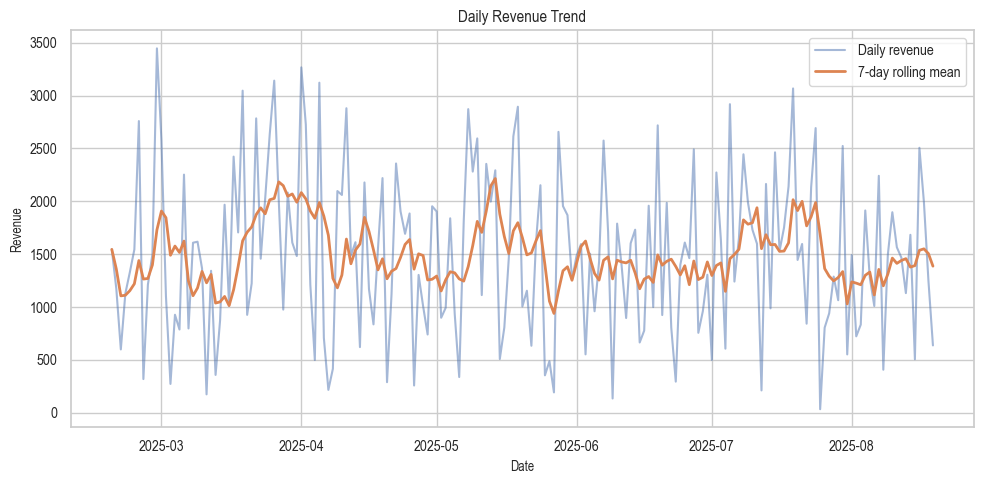

In [16]:

daily_sales = (
    df.set_index('Date')['Subtotal']
      .resample('D')
      .sum()
      .fillna(0)
)
rolling = daily_sales.rolling(window=7, min_periods=1).mean()

plt.figure()
plt.plot(daily_sales.index, daily_sales.values, alpha=0.5, label='Daily revenue')
plt.plot(rolling.index, rolling.values, label='7-day rolling mean', linewidth=2)
plt.title('Daily Revenue Trend')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\FCT\AppData\Local\Temp\ipykernel_8836\3981014087.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby([pd.Grouper(key='Date', freq='M'), 'Broad_Category'])['Subtotal']


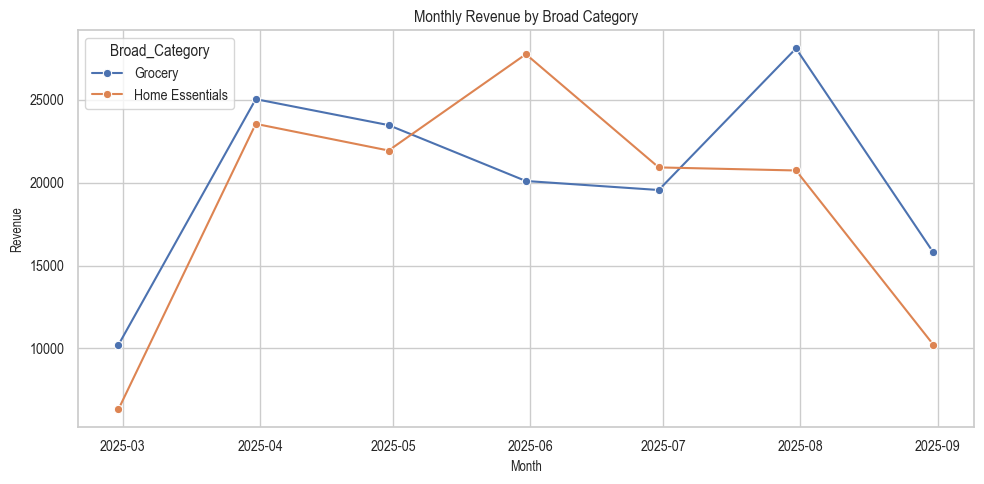

In [17]:

monthly_category = (
    df.groupby([pd.Grouper(key='Date', freq='M'), 'Broad_Category'])['Subtotal']
      .sum()
      .reset_index()
)
plt.figure()
sns.lineplot(data=monthly_category, x='Date', y='Subtotal', hue='Broad_Category', marker='o')
plt.title('Monthly Revenue by Broad Category')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()



## 8. Basket & Co-Purchase Signals

Paired product insights support later recommendation logic.


In [18]:

# Approximate orders by grouping on (Date, Customer_ID) and summarise product combinations.
order_groups = df.groupby(['Customer_ID', 'Date'])['Product_Display_Name'].apply(lambda x: sorted(set(x)))

from collections import Counter
pair_counter = Counter()
for products in order_groups:
    if len(products) < 2:
        continue
    for i in range(len(products)):
        for j in range(i + 1, len(products)):
            pair_counter[(products[i], products[j])] += 1

pairs = (
    pd.DataFrame([
        {'product_a': a, 'product_b': b, 'cooccurrences': cnt}
        for (a, b), cnt in pair_counter.most_common()
    ])
    .head(15)
)
pairs


,product_a,product_b,cooccurrences
0,Product 77,Product 85,1
1,Product 77,Product 94,1
2,Product 85,Product 94,1
3,Product 20,Product 82,1
4,Product 4,Product 55,1
5,Product 28,Product 71,1
6,Product 18,Product 57,1
7,Product 28,Product 82,1
8,Product 100,Product 44,1
9,Product 4,Product 92,1



## 9. Key Takeaways

Summarise actionable observations discovered during EDA.



- Grocery and Home Essentials split revenue, indicating the assistant should reason across both assortments.
- Wholesale buyers exhibit wider price dispersion and higher spend concentration than retail buyers.
- Rolling revenue trend highlights recent growth spurts worth feeding into temporal reasoning.
- Product pairings reveal cross-sell opportunities for the assistant to surface.
